# Bucketed Analysis Notebook (V3 - Active Buckets Visualization)

This notebook demonstrates the V2 simulation workflow with automatic per-side padding:
1. Load data without manual padding
2. Run simulation (splitting/padding handled internally)
3. Benchmark with multiple runs and timing statistics
4. Convert outputs to sparse format
5. Visualize results
6. **NEW: Visualize active buckets per plane**

**Key V2 Changes:**
- No more `MAX_HITS_PADDING` - padding tiers chosen automatically
- Data split by side (east/west) internally for efficiency
- Built-in pre/post simulation validation

In [1]:
# =============================================================================
# CONFIGURATION
# =============================================================================

# Toggle bucketed mode: True uses sparse accumulation
RUN_BUCKETED = True

# Data configuration
config_path = "config/cubic_wireplane_config.yaml"
data_path = "mpvmpr_20.h5"
event_idx = 7

# Simulation parameters (no more MAX_HITS_PADDING!)
num_s = 16
response_path = "tools_old/responses/"
track_threshold = 500.0

# Bucketed mode parameters (only used if RUN_BUCKETED=True)
MAX_ACTIVE_BUCKETS = 4000

# Timing configuration
NUM_TIMING_RUNS = 5  # Number of runs to average for timing

print(f"Configuration:")
print(f"  RUN_BUCKETED: {RUN_BUCKETED}")
print(f"  Data: {data_path}, Event: {event_idx}")
print(f"  Timing runs: {NUM_TIMING_RUNS}")

Configuration:
  RUN_BUCKETED: True
  Data: mpvmpr_20.h5, Event: 7
  Timing runs: 5


In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import time
import gc

# Import from V2 refactored module (with per-side padding)
from tools.simulation import (
    DetectorSimulator,
    PADDING_TIERS,
    pick_padding_tier,
)
from tools.config import (
    DepositData,
    create_diffusion_params,
    create_track_hits_config,
)
from tools.geometry import generate_detector
from tools.loader import load_particle_step_data
from tools.recombination import recombine_steps

# Import sparse utilities
from tools.sparse_utils import dense_to_sparse, sparse_buckets_to_sparse, sparse_to_dense

# Import visualization functions
from tools.visualization import (
    visualize_wire_signals,
    visualize_diffused_charge,
    visualize_track_labels,
    get_top_tracks_by_charge,
)

os.makedirs("plots", exist_ok=True)

print(f"JAX version: {jax.__version__}")
print(f"JAX devices: {jax.devices()}")
print(f"Available padding tiers: {PADDING_TIERS}")

JAX version: 0.6.0
JAX devices: [CudaDevice(id=0)]
Available padding tiers: (50000, 75000, 150000, 250000000, 350000, 450000, 550000, 650000, 750000, 850000, 950000, 1000000)


## Load Data

Note: No manual padding needed! The simulation handles splitting and padding internally.

In [3]:
# Load detector config
detector_config = generate_detector(config_path)

# Create diffusion params
diffusion_params = create_diffusion_params(
    max_sigma_trans_unitless=detector_config['max_sigma_trans_unitless'],
    max_sigma_long_unitless=detector_config['max_sigma_long_unitless'],
    num_s=num_s,
    n_sigma=3.0
)

# Create track config
track_config = create_track_hits_config(threshold=track_threshold)

print(f"Detector config loaded")
print(f"  K_wire = {diffusion_params.K_wire}")
print(f"  K_time = {diffusion_params.K_time}")

Detector config loaded
  K_wire = 3
  K_time = 5


In [4]:
# Load event data (NO PADDING - handled internally by simulator)
print(f"\n--- Loading Event {event_idx} ---")
step_data = load_particle_step_data(data_path, event_idx)

# Extract arrays
positions_mm = jnp.asarray(step_data.get('position', jnp.empty((0, 3))), dtype=jnp.float32)
n_hits = positions_mm.shape[0]
print(f"Loaded {n_hits:,} steps")

# Get recombined charge
charges = jnp.asarray(recombine_steps(step_data, detector_config), dtype=jnp.float32)
theta = jnp.asarray(step_data.get('theta', jnp.zeros((n_hits,))), dtype=jnp.float32)
phi = jnp.asarray(step_data.get('phi', jnp.zeros((n_hits,))), dtype=jnp.float32)
track_ids = jnp.asarray(step_data.get('track_id', jnp.ones((n_hits,))), dtype=jnp.int32)

n_unique_tracks = len(jnp.unique(track_ids))
print(f"Unique tracks: {n_unique_tracks:,}")

# Show east/west split preview
x_mm = positions_mm[:, 0]
n_east = int(jnp.sum(x_mm < 0))
n_west = int(jnp.sum(x_mm >= 0))
print(f"\nSide distribution:")
print(f"  East (x<0):  {n_east:,} hits -> will use tier {pick_padding_tier(n_east):,}")
print(f"  West (x>=0): {n_west:,} hits -> will use tier {pick_padding_tier(n_west):,}")

# Create DepositData (NO PADDING - all valid!)
deposit_data = DepositData(
    positions_mm=positions_mm,
    charges=charges,
    valid_mask=jnp.ones(n_hits, dtype=bool),  # All entries are valid
    theta=theta,
    phi=phi,
    track_ids=track_ids
)

print("\nData prepared (no manual padding needed).")


--- Loading Event 7 ---
Loaded 205,757 steps
Unique tracks: 5,908

Side distribution:
  East (x<0):  137,070 hits -> will use tier 150,000
  West (x>=0): 68,687 hits -> will use tier 75,000

Data prepared (no manual padding needed).


## Create Simulator and Run

In [5]:
# Clear caches
jax.clear_caches()
gc.collect()

mode_str = "BUCKETED" if RUN_BUCKETED else "DENSE"
print("\n" + "="*60)
print(f" {mode_str} MODE SIMULATION (V2 - Per-Side Padding)")
print("="*60)

# Create simulator (no max_hits_pad needed!)
if RUN_BUCKETED:
    simulator = DetectorSimulator(
        detector_config,
        response_path=response_path,
        track_config=track_config,
        diffusion_params=diffusion_params,
        use_bucketed=True,
        max_active_buckets=MAX_ACTIVE_BUCKETS
    )
else:
    simulator = DetectorSimulator(
        detector_config,
        response_path=response_path,
        track_config=track_config,
        diffusion_params=diffusion_params,
        use_bucketed=False
    )

# Warm up JIT (compiles for smallest tier)
print("\nWarming up JIT...")
simulator.warm_up()
print("Initial JIT compilation complete.")


 BUCKETED MODE SIMULATION (V2 - Per-Side Padding)
--- Creating DetectorSimulator (V2 - Per-Side Padding) ---
   Extracting parameters...
   Loading response kernels...
   Config: tiers=(50000, 75000, 150000, 250000000, 350000, 450000, 550000, 650000, 750000, 850000, 950000, 1000000), num_s=16, K_wire=3, K_time=5
   Using BUCKETED accumulation (B=2*kernel, max_buckets=4000)
--- DetectorSimulator Ready ---

Warming up JIT...
Triggering JIT compilation...
JIT compilation finished (tier 50,000). Other tiers compile on first use.
Initial JIT compilation complete.


In [6]:
# First run - may trigger additional JIT compilation for actual tier sizes
print("\nFirst simulation run (may compile for actual data tiers)...")
start_time = time.time()

response_signals, track_hits = simulator(deposit_data)

# Wait for GPU completion
if RUN_BUCKETED:
    for key, val in response_signals.items():
        if val is not None:
            jax.block_until_ready(val[0])
else:
    for arr in response_signals.values():
        if arr is not None:
            jax.block_until_ready(arr)

first_run_time = time.time() - start_time
print(f"First run completed in {first_run_time:.2f}s (includes any tier-specific JIT)")


First simulation run (may compile for actual data tiers)...
   Splitting and padding data by side...
   East side: 137,070 hits -> tier 150,000
   West side: 68,687 hits -> tier 75,000
First run completed in 75.99s (includes any tier-specific JIT)


## Timing Benchmark

Run multiple iterations after JIT compilation to get accurate timing statistics.

In [7]:
# Timing benchmark - run multiple times and average
print(f"\n--- Timing Benchmark ({NUM_TIMING_RUNS} runs) ---")
print("Running after JIT compilation...\n")

timing_results = []

for run_idx in range(NUM_TIMING_RUNS):
    # Clear any cached results
    gc.collect()
    
    # Time the simulation
    start_time = time.time()
    
    response_signals, track_hits = simulator(deposit_data)
    
    # Wait for GPU completion
    if RUN_BUCKETED:
        for key, val in response_signals.items():
            if val is not None:
                jax.block_until_ready(val[0])
    else:
        for arr in response_signals.values():
            if arr is not None:
                jax.block_until_ready(arr)
    
    elapsed = time.time() - start_time
    timing_results.append(elapsed)
    print(f"  Run {run_idx + 1}: {elapsed:.3f}s")

# Calculate statistics
timing_array = np.array(timing_results)
mean_time = np.mean(timing_array)
std_time = np.std(timing_array)
min_time = np.min(timing_array)
max_time = np.max(timing_array)

print(f"\n--- Timing Statistics ---")
print(f"  Mean:   {mean_time:.3f}s")
print(f"  Std:    {std_time:.3f}s")
print(f"  Min:    {min_time:.3f}s")
print(f"  Max:    {max_time:.3f}s")
print(f"  Range:  {max_time - min_time:.3f}s")

# Throughput
hits_per_second = n_hits / mean_time
print(f"\n  Throughput: {hits_per_second:,.0f} hits/second")
print(f"  Time per 100k hits: {100_000 / hits_per_second:.3f}s")


--- Timing Benchmark (5 runs) ---
Running after JIT compilation...

   Splitting and padding data by side...
   East side: 137,070 hits -> tier 150,000
   West side: 68,687 hits -> tier 75,000
  Run 1: 0.839s
   Splitting and padding data by side...
   East side: 137,070 hits -> tier 150,000
   West side: 68,687 hits -> tier 75,000
  Run 2: 0.783s
   Splitting and padding data by side...
   East side: 137,070 hits -> tier 150,000
   West side: 68,687 hits -> tier 75,000
  Run 3: 0.809s
   Splitting and padding data by side...
   East side: 137,070 hits -> tier 150,000
   West side: 68,687 hits -> tier 75,000
  Run 4: 0.783s
   Splitting and padding data by side...
   East side: 137,070 hits -> tier 150,000
   West side: 68,687 hits -> tier 75,000
  Run 5: 0.739s

--- Timing Statistics ---
  Mean:   0.791s
  Std:    0.033s
  Min:    0.739s
  Max:    0.839s
  Range:  0.099s

  Throughput: 260,270 hits/second
  Time per 100k hits: 0.384s


## Active Buckets Analysis

Extract and analyze the active buckets from the bucketed simulation output.

In [8]:
# Analyze active buckets in each plane
print("\n--- Active Buckets Analysis ---")

# Create simulation_params dict for analysis
simulation_params = {
    'num_time_steps': detector_config['num_time_steps'],
    'time_step_size_us': detector_config['time_step_size_us'],
    'num_wires_actual': detector_config['num_wires_actual'],
    'max_abs_indices': detector_config['max_wire_indices_abs'],
    'min_abs_indices': detector_config['min_wire_indices_abs'],
}

num_time_steps = simulation_params['num_time_steps']
num_wires_actual = simulation_params['num_wires_actual']

# Store bucket info for visualization
bucket_info = {}

if RUN_BUCKETED:
    print(f"\n{'Plane':<12} {'Active':>8} {'Total':>10} {'Coverage':>10} {'B1':>6} {'B2':>6}")
    print("-" * 60)
    
    for plane_key in response_signals.keys():
        side_idx, plane_idx = plane_key
        num_wires = int(num_wires_actual[side_idx, plane_idx])
        
        buckets, num_active, compact_to_key, B1, B2 = response_signals[plane_key]
        num_active_int = int(num_active)
        B1_int = int(B1)
        B2_int = int(B2)
        
        # Calculate total possible buckets
        num_buckets_w = (num_wires + B1_int - 1) // B1_int
        num_buckets_t = (num_time_steps + B2_int - 1) // B2_int
        total_buckets = num_buckets_w * num_buckets_t
        
        coverage_pct = (num_active_int / total_buckets) * 100 if total_buckets > 0 else 0
        
        # Store for visualization
        bucket_info[plane_key] = {
            'num_active': num_active_int,
            'total_buckets': total_buckets,
            'num_buckets_w': num_buckets_w,
            'num_buckets_t': num_buckets_t,
            'B1': B1_int,
            'B2': B2_int,
            'compact_to_key': np.array(compact_to_key[:num_active_int]),
            'coverage_pct': coverage_pct
        }
        
        plane_name = f"({side_idx},{plane_idx})"
        print(f"{plane_name:<12} {num_active_int:>8,} {total_buckets:>10,} {coverage_pct:>9.2f}% {B1_int:>6} {B2_int:>6}")
    
    print("\n" + "-" * 60)
    total_active = sum(info['num_active'] for info in bucket_info.values())
    total_possible = sum(info['total_buckets'] for info in bucket_info.values())
    overall_coverage = (total_active / total_possible) * 100 if total_possible > 0 else 0
    print(f"{'TOTAL':<12} {total_active:>8,} {total_possible:>10,} {overall_coverage:>9.2f}%")
else:
    print("Not running in bucketed mode - no bucket analysis available.")


--- Active Buckets Analysis ---

Plane          Active      Total   Coverage     B1     B2
------------------------------------------------------------
(0,0)             173        550     31.45%     40    252
(0,1)             158        550     28.73%     40    252
(0,2)             182        407     44.72%     40    252
(1,0)             158        550     28.73%     40    252
(1,1)             138        550     25.09%     40    252
(1,2)             175        407     43.00%     40    252

------------------------------------------------------------
TOTAL             984      3,014     32.65%


## Visualization: Active Buckets

Visualize which buckets are active (contain signal) vs empty across all planes.


--- Visualizing Active Buckets ---
Saved to plots/v3_active_buckets.png


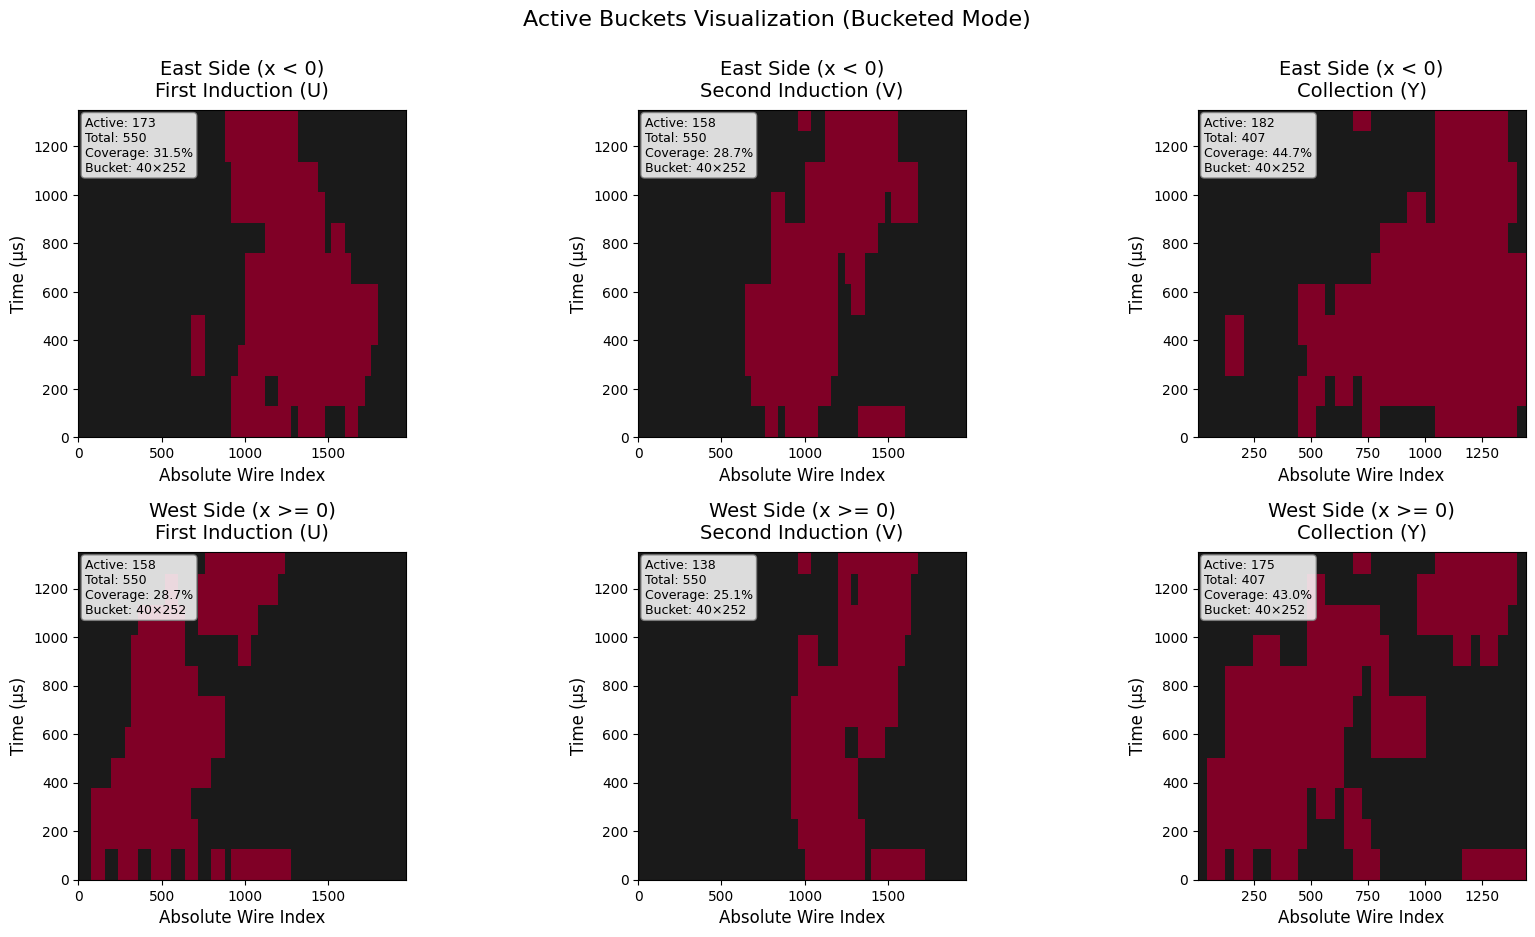

In [9]:
def visualize_active_buckets(response_signals, simulation_params, figsize=(20, 10)):
    """
    Visualize active buckets in the bucketed simulation output.
    
    Active buckets are shown as colored rectangles, empty buckets as dark background.
    Shows the number of active buckets and coverage percentage for each plane.
    
    Parameters
    ----------
    response_signals : dict
        Dictionary of response signals from bucketed simulation.
        Each entry is (buckets, num_active, compact_to_key, B1, B2).
    simulation_params : dict
        Dictionary containing simulation parameters.
    figsize : tuple
        Figure size (width, height) in inches.
        
    Returns
    -------
    matplotlib.figure.Figure
        The matplotlib Figure object.
    """
    num_time_steps = simulation_params['num_time_steps']
    time_step_size_us = simulation_params['time_step_size_us']
    num_wires_actual = simulation_params['num_wires_actual']
    max_abs_indices = simulation_params['max_abs_indices']
    min_abs_indices = simulation_params['min_abs_indices']
    
    side_names = ['East Side (x < 0)', 'West Side (x >= 0)']
    plane_types = ['First Induction (U)', 'Second Induction (V)', 'Collection (Y)']
    
    # Create figure
    fig = plt.figure(figsize=figsize, facecolor='white')
    gs = gridspec.GridSpec(2, 3, figure=fig, hspace=0.35, wspace=0.30)
    max_time_axis = num_time_steps * time_step_size_us
    title_size, label_size, tick_size = 14, 12, 10
    
    for side_idx in range(2):
        for plane_idx in range(3):
            ax = fig.add_subplot(gs[side_idx, plane_idx])
            ax.set_facecolor('#1a1a1a')  # Dark background for empty regions
            
            plane_key = (side_idx, plane_idx)
            min_idx_abs = int(min_abs_indices[side_idx, plane_idx])
            max_idx_abs = int(max_abs_indices[side_idx, plane_idx])
            num_wires = int(num_wires_actual[side_idx, plane_idx])
            
            if plane_key not in response_signals:
                ax.text(0.5, 0.5, "(No data)", color='grey', ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f"{side_names[side_idx]}\n{plane_types[plane_idx]}", fontsize=title_size, pad=10)
                continue
            
            # Extract bucket info
            buckets, num_active, compact_to_key, B1, B2 = response_signals[plane_key]
            num_active_int = int(num_active)
            B1_int = int(B1)
            B2_int = int(B2)
            
            # Calculate bucket grid dimensions
            num_buckets_w = (num_wires + B1_int - 1) // B1_int
            num_buckets_t = (num_time_steps + B2_int - 1) // B2_int
            total_buckets = num_buckets_w * num_buckets_t
            coverage_pct = (num_active_int / total_buckets) * 100 if total_buckets > 0 else 0
            
            # Decode active bucket positions
            active_keys = np.array(compact_to_key[:num_active_int])
            bucket_w_indices = active_keys // num_buckets_t
            bucket_t_indices = active_keys % num_buckets_t
            
            # Create a grid showing bucket activity
            bucket_grid = np.zeros((num_buckets_w, num_buckets_t))
            for bw, bt in zip(bucket_w_indices, bucket_t_indices):
                if 0 <= bw < num_buckets_w and 0 <= bt < num_buckets_t:
                    bucket_grid[bw, bt] = 1
            
            # Convert bucket grid coordinates to wire/time coordinates
            extent = [
                min_idx_abs,  # Wire min
                min_idx_abs + num_buckets_w * B1_int,  # Wire max (approximate)
                0,  # Time min
                num_buckets_t * B2_int * time_step_size_us  # Time max (approximate)
            ]
            
            # Use a colormap that shows active buckets clearly
            cmap = plt.cm.YlOrRd.copy()
            cmap.set_under('#1a1a1a')  # Empty buckets are dark
            
            im = ax.imshow(
                bucket_grid.T,
                aspect='auto',
                origin='lower',
                extent=extent,
                cmap=cmap,
                vmin=0.5,  # Only show values > 0.5 (i.e., active buckets)
                vmax=1.0,
                interpolation='nearest'
            )
            
            # Set axis limits
            ax.set_xlim(min_idx_abs, max_idx_abs + 1)
            ax.set_ylim(0, max_time_axis)
            ax.set_box_aspect(1)
            
            # Title with active bucket count
            plot_title = f"{side_names[side_idx]}\n{plane_types[plane_idx]}"
            ax.set_title(plot_title, fontsize=title_size, pad=10)
            
            ax.set_xlabel('Absolute Wire Index', fontsize=label_size)
            ax.set_ylabel('Time (μs)', fontsize=label_size)
            ax.tick_params(axis='both', which='major', labelsize=tick_size)
            
            # Add info box with bucket statistics
            info_text = f"Active: {num_active_int:,}\nTotal: {total_buckets:,}\nCoverage: {coverage_pct:.1f}%\nBucket: {B1_int}×{B2_int}"
            ax.text(
                0.02, 0.98, info_text,
                transform=ax.transAxes,
                va='top', ha='left',
                fontsize=9,
                bbox=dict(facecolor='white', alpha=0.85, edgecolor='gray', boxstyle='round,pad=0.3')
            )
    
    fig.suptitle('Active Buckets Visualization (Bucketed Mode)', fontsize=16, y=0.98)
    return fig


# Run the visualization
if RUN_BUCKETED:
    print("\n--- Visualizing Active Buckets ---")
    fig_buckets = visualize_active_buckets(response_signals, simulation_params)
    fig_buckets.savefig("plots/v3_active_buckets.png", dpi=300, bbox_inches='tight', facecolor='white')
    print("Saved to plots/v3_active_buckets.png")
    plt.show()
else:
    print("Not running in bucketed mode - skipping bucket visualization.")

## Convert to Sparse Format

In [10]:
# Convert response signals to truly sparse format
print("\n--- Converting Response Signals to Sparse Format ---")
response_sparse = {}

for plane_key in response_signals.keys():
    side_idx, plane_idx = plane_key
    num_wires = int(num_wires_actual[side_idx, plane_idx])
    
    if RUN_BUCKETED:
        buckets, num_active, compact_to_key, B1, B2 = response_signals[plane_key]
        indices, values = sparse_buckets_to_sparse(
            buckets, compact_to_key, num_active,
            int(B1), int(B2), num_wires, num_time_steps,
            threshold=0.0
        )
    else:
        dense_arr = response_signals[plane_key]
        indices, values = dense_to_sparse(dense_arr, threshold=0.0)
    
    response_sparse[plane_key] = (indices, values)
    
    total_elements = num_wires * num_time_steps
    num_nonzero = len(values)
    compression = (1 - num_nonzero / total_elements) * 100 if total_elements > 0 else 0
    print(f"  Plane {plane_key}: {num_nonzero:,} non-zero / {total_elements:,} total ({compression:.1f}% sparse)")

print("\nConversion complete!")


--- Converting Response Signals to Sparse Format ---
  Plane (0, 0): 792,902 non-zero / 5,318,269 total (85.1% sparse)
  Plane (0, 1): 723,109 non-zero / 5,318,269 total (86.4% sparse)
  Plane (0, 2): 853,280 non-zero / 3,892,141 total (78.1% sparse)
  Plane (1, 0): 611,229 non-zero / 5,318,269 total (88.5% sparse)
  Plane (1, 1): 525,514 non-zero / 5,318,269 total (90.1% sparse)
  Plane (1, 2): 577,394 non-zero / 3,892,141 total (85.2% sparse)

Conversion complete!


## Convert Sparse to Dense (for Visualization)

In [11]:
# Convert truly sparse back to dense for visualization
print("\n--- Converting Sparse to Dense for Visualization ---")
response_dense = {}

for plane_key, (indices, values) in response_sparse.items():
    side_idx, plane_idx = plane_key
    num_wires = int(num_wires_actual[side_idx, plane_idx])
    
    dense_arr = sparse_to_dense(indices, values, num_wires, num_time_steps)
    response_dense[plane_key] = dense_arr
    print(f"  Plane {plane_key}: sparse ({len(values):,}) -> dense {dense_arr.shape}")

print("\nReady for visualization!")


--- Converting Sparse to Dense for Visualization ---
  Plane (0, 0): sparse (792,902) -> dense (1969, 2701)
  Plane (0, 1): sparse (723,109) -> dense (1969, 2701)
  Plane (0, 2): sparse (853,280) -> dense (1441, 2701)
  Plane (1, 0): sparse (611,229) -> dense (1969, 2701)
  Plane (1, 1): sparse (525,514) -> dense (1969, 2701)
  Plane (1, 2): sparse (577,394) -> dense (1441, 2701)

Ready for visualization!


## Visualization 1: Response Signals


--- Response Signals (WITH Detector Response) ---
   Visualization Norms by Plane Type:
   - U-plane: min=-2.40e+04, max=2.40e+04
   - V-plane: min=-2.40e+04, max=2.40e+04
   - Y-plane: min=-1.29e+05, max=1.29e+05
Saved to plots/v3_response_signals.png


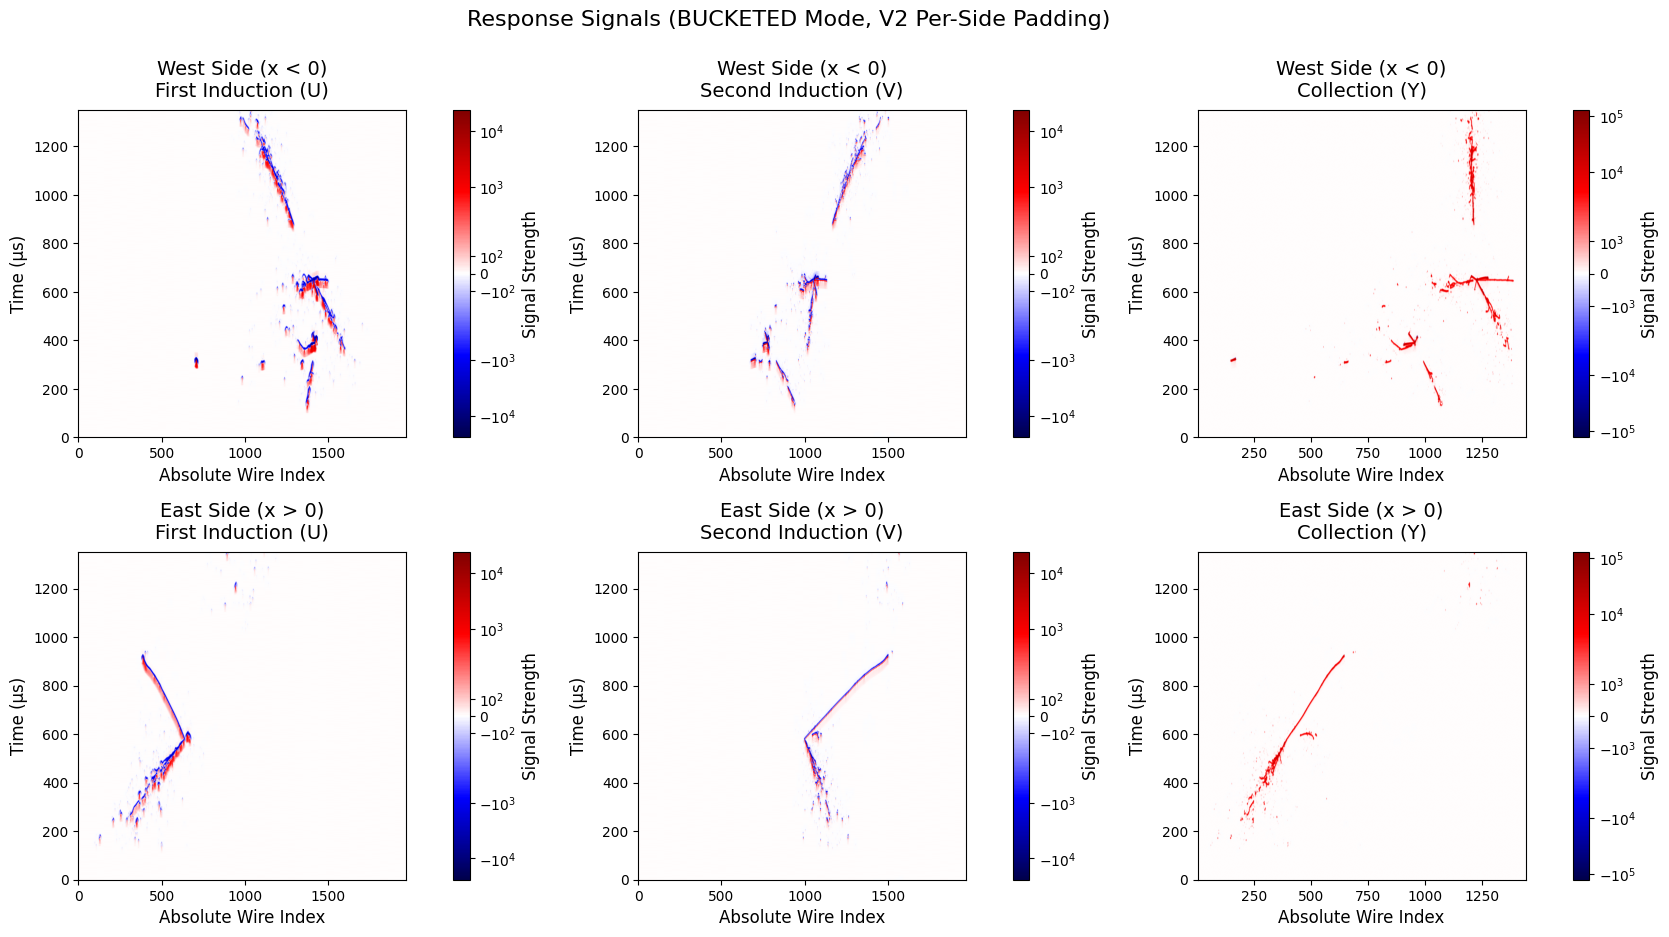

In [12]:
# Visualize response signals
print("\n--- Response Signals (WITH Detector Response) ---")
fig_response = visualize_wire_signals(response_dense, simulation_params, log_norm=True)
fig_response.suptitle(f'Response Signals ({mode_str} Mode, V2 Per-Side Padding)', fontsize=16)
fig_response.savefig("plots/v3_response_signals.png", dpi=300, bbox_inches='tight', facecolor='white')
print("Saved to plots/v3_response_signals.png")
plt.show()

## Visualization 2: Hit Signals (from track_hits)

In [13]:
# Convert sparse track_hits to dense for visualization
def sparse_track_hits_to_dense(track_hits_dict, simulation_params):
    """Convert sparse track hits to dense 2D arrays for visualization."""
    dense_signals = {}
    
    num_time_steps = simulation_params['num_time_steps']
    num_wires_actual = simulation_params['num_wires_actual']
    min_abs_indices = simulation_params['min_abs_indices']
    
    for plane_key, results in track_hits_dict.items():
        side_idx, plane_idx = plane_key
        num_wires = int(num_wires_actual[side_idx, plane_idx])
        min_wire_idx = int(min_abs_indices[side_idx, plane_idx])
        
        dense_array = jnp.zeros((num_wires, num_time_steps))
        
        if results['num_hits'] > 0:
            track_hits_data = results['hits_by_track'][:results['num_hits']]
            wire_indices_abs = track_hits_data[:, 0].astype(jnp.int32)
            time_indices = track_hits_data[:, 1].astype(jnp.int32)
            charges = track_hits_data[:, 2]
            
            wire_indices_rel = wire_indices_abs - min_wire_idx
            valid = (wire_indices_rel >= 0) & (wire_indices_rel < num_wires) & \
                    (time_indices >= 0) & (time_indices < num_time_steps)
            
            dense_array = dense_array.at[wire_indices_rel[valid], time_indices[valid]].add(charges[valid])
        
        dense_signals[plane_key] = dense_array
    
    return dense_signals

# Convert
print("Computing dense hit signals from sparse track_hits...")
computed_hit_signals = sparse_track_hits_to_dense(track_hits, simulation_params)

for plane_key, dense in computed_hit_signals.items():
    num_hits = int(track_hits[plane_key]['num_hits'])
    print(f"  Plane {plane_key}: {num_hits:,} sparse hits -> dense {dense.shape}")
print("Done!")

Computing dense hit signals from sparse track_hits...
  Plane (0, 0): 77,709 sparse hits -> dense (1969, 2701)
  Plane (0, 1): 77,125 sparse hits -> dense (1969, 2701)
  Plane (0, 2): 77,223 sparse hits -> dense (1441, 2701)
  Plane (1, 0): 31,876 sparse hits -> dense (1969, 2701)
  Plane (1, 1): 31,393 sparse hits -> dense (1969, 2701)
  Plane (1, 2): 29,763 sparse hits -> dense (1441, 2701)
Done!



--- Hit Signals (Computed from Sparse track_hits) ---
   Diffused Charge Range: min=5.33e+02, max=1.13e+06
Saved to plots/v3_hit_signals.png


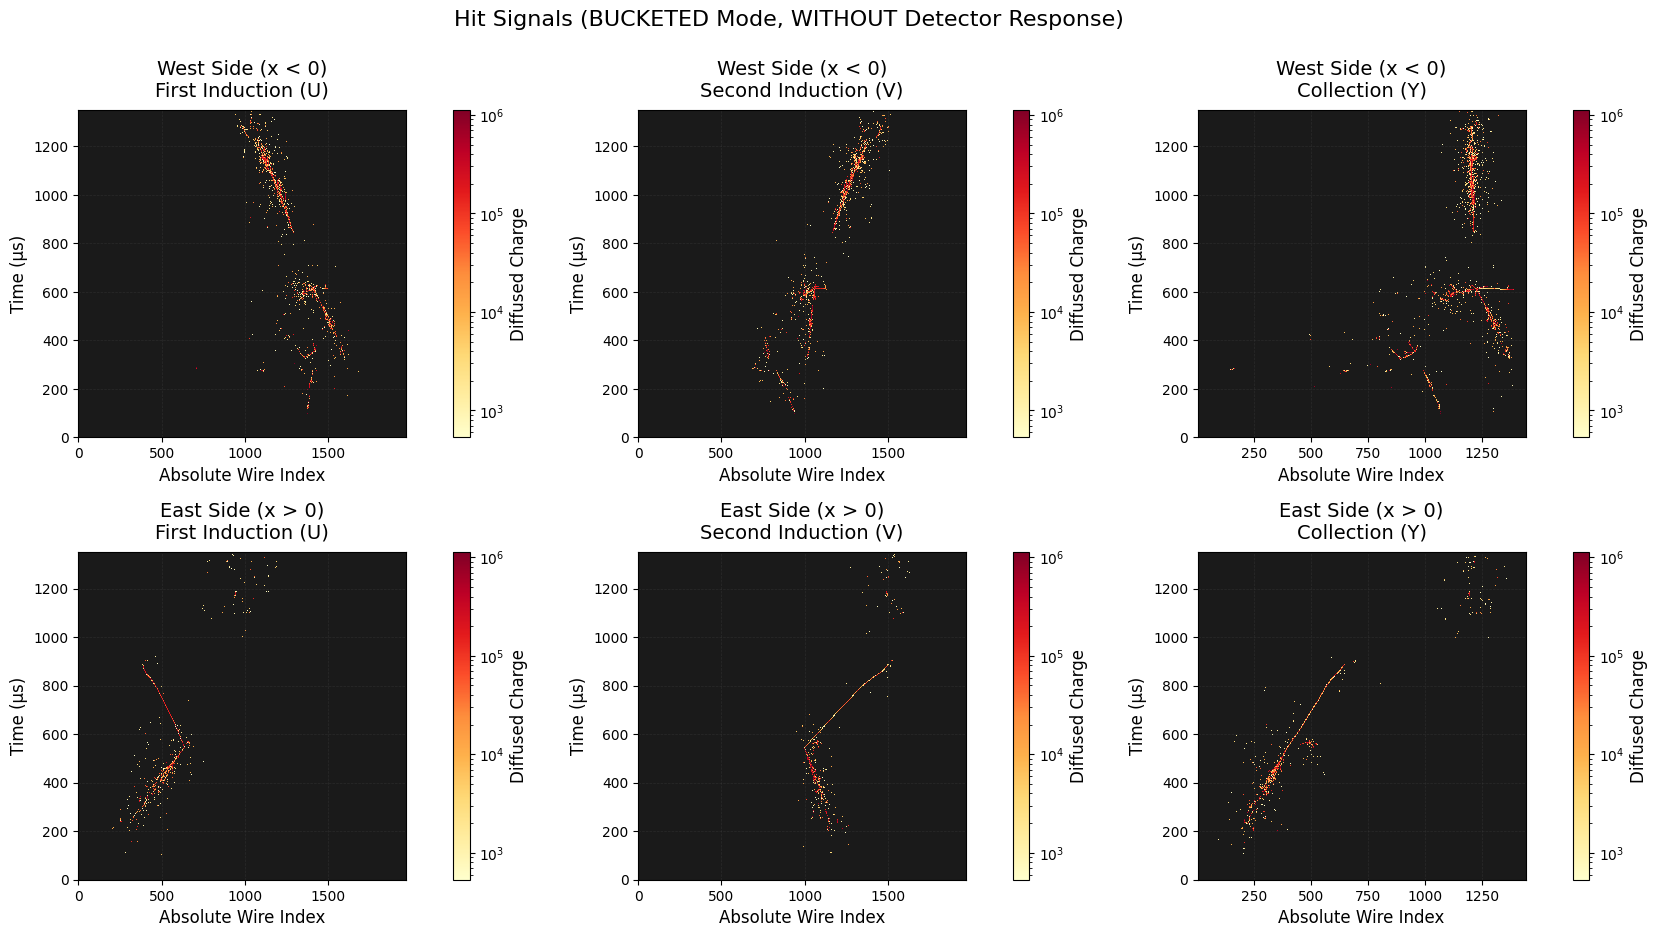

In [14]:
# Visualize hit signals
print("\n--- Hit Signals (Computed from Sparse track_hits) ---")
fig_hits = visualize_diffused_charge(computed_hit_signals, simulation_params, log_norm=True, threshold=50)
fig_hits.suptitle(f'Hit Signals ({mode_str} Mode, WITHOUT Detector Response)', fontsize=16)
fig_hits.savefig("plots/v3_hit_signals.png", dpi=300, bbox_inches='tight', facecolor='white')
print("Saved to plots/v3_hit_signals.png")
plt.show()

## Visualization 3: Track Labels


--- Track Labels ---
Top 10 tracks by total charge:
   1. Track   10: 1,183,882,112.0
   2. Track   16: 673,495,680.0
   3. Track    1: 558,441,408.0
   4. Track   20: 534,556,864.0
   5. Track    5: 518,011,328.0
   6. Track 4071: 462,392,896.0
   7. Track   19: 423,092,896.0
   8. Track    2: 333,229,760.0
   9. Track    7: 306,848,640.0
  10. Track  683: 299,239,968.0


/home/oalterka/desktop_linux/JAXTPC/tools/visualization.py:908: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



Saved to plots/v3_track_labels.png


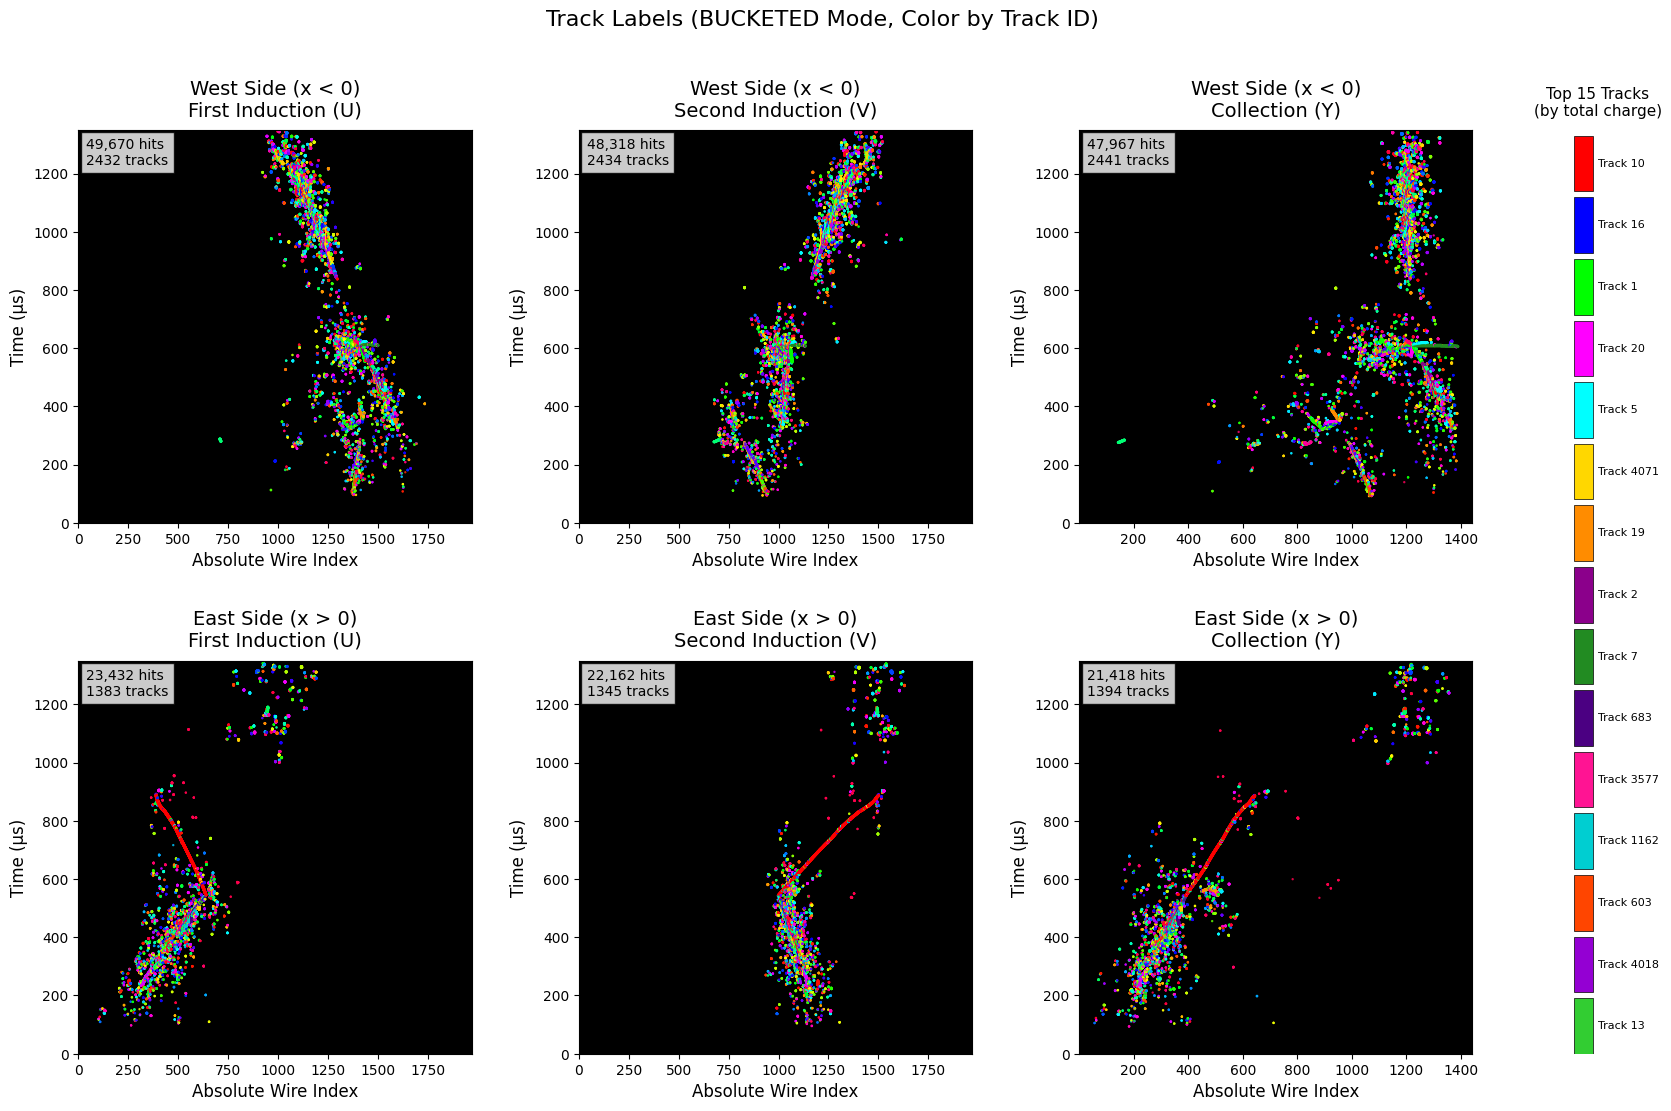

In [15]:
# Get top tracks and visualize
print("\n--- Track Labels ---")
top_tracks_by_charge = get_top_tracks_by_charge(track_hits, top_n=20)

if top_tracks_by_charge:
    print(f"Top 10 tracks by total charge:")
    for i, (tid, charge) in enumerate(top_tracks_by_charge[:10]):
        print(f"  {i+1:2d}. Track {tid:4d}: {charge:12,.1f}")

fig_tracks = visualize_track_labels(track_hits, simulation_params, top_tracks_by_charge, max_tracks=15)
fig_tracks.suptitle(f'Track Labels ({mode_str} Mode, Color by Track ID)', fontsize=16)
fig_tracks.savefig("plots/v3_track_labels.png", dpi=300, bbox_inches='tight', facecolor='white')
print("\nSaved to plots/v3_track_labels.png")
plt.show()

## Summary

In [16]:
print("\n" + "="*60)
print(" SUMMARY")
print("="*60)

print(f"\nConfiguration:")
print(f"  Mode: {mode_str}")
print(f"  Event: {event_idx}")
print(f"  Total hits: {n_hits:,}")
print(f"  East side: {n_east:,} hits")
print(f"  West side: {n_west:,} hits")

print(f"\nTiming Results ({NUM_TIMING_RUNS} runs, post-JIT):")
print(f"  Mean: {mean_time:.3f}s +/- {std_time:.3f}s")
print(f"  Throughput: {hits_per_second:,.0f} hits/second")

if RUN_BUCKETED:
    print(f"\nActive Buckets Summary:")
    for plane_key, info in bucket_info.items():
        print(f"  Plane {plane_key}: {info['num_active']:,} active / {info['total_buckets']:,} total ({info['coverage_pct']:.1f}% coverage)")

print(f"\nSparse format stats:")
total_sparse_elements = 0
total_dense_elements = 0
for plane_key, (indices, values) in response_sparse.items():
    side_idx, plane_idx = plane_key
    num_wires = int(num_wires_actual[side_idx, plane_idx])
    dense_size = num_wires * num_time_steps
    sparse_size = len(values)
    total_sparse_elements += sparse_size
    total_dense_elements += dense_size
    print(f"  Plane {plane_key}: {sparse_size:,} non-zero values")

overall_compression = (1 - total_sparse_elements / total_dense_elements) * 100
print(f"\nOverall compression: {overall_compression:.1f}% sparse")
print(f"  Total non-zero: {total_sparse_elements:,}")
print(f"  Total dense elements: {total_dense_elements:,}")

print(f"\nPlots saved to ./plots/:")
print(f"  - v3_active_buckets.png (NEW!)")
print(f"  - v3_response_signals.png")
print(f"  - v3_hit_signals.png")
print(f"  - v3_track_labels.png")


 SUMMARY

Configuration:
  Mode: BUCKETED
  Event: 7
  Total hits: 205,757
  East side: 137,070 hits
  West side: 68,687 hits

Timing Results (5 runs, post-JIT):
  Mean: 0.791s +/- 0.033s
  Throughput: 260,270 hits/second

Active Buckets Summary:
  Plane (0, 0): 173 active / 550 total (31.5% coverage)
  Plane (0, 1): 158 active / 550 total (28.7% coverage)
  Plane (0, 2): 182 active / 407 total (44.7% coverage)
  Plane (1, 0): 158 active / 550 total (28.7% coverage)
  Plane (1, 1): 138 active / 550 total (25.1% coverage)
  Plane (1, 2): 175 active / 407 total (43.0% coverage)

Sparse format stats:
  Plane (0, 0): 792,902 non-zero values
  Plane (0, 1): 723,109 non-zero values
  Plane (0, 2): 853,280 non-zero values
  Plane (1, 0): 611,229 non-zero values
  Plane (1, 1): 525,514 non-zero values
  Plane (1, 2): 577,394 non-zero values

Overall compression: 85.9% sparse
  Total non-zero: 4,083,428
  Total dense elements: 29,057,358

Plots saved to ./plots/:
  - v3_active_buckets.png (NEW